<a href="https://colab.research.google.com/github/michalinahulak/Fake_News_Detection/blob/main/3_FakeNewsnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ydata-profiling

In [ ]:
!pip install --upgrade gensim

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install optuna

# Imports

In [ ]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from wordcloud import WordCloud, STOPWORDS
import string
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

from sentence_transformers import SentenceTransformer

from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import optuna

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!ls -la '/content/drive/My Drive/Colab Notebooks/upskill/Fake News Classification'

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/upskill/Fake News Classification

In [ ]:
import functions
from functions import generate_word_cloud, remove_stopwords_and_punctuation, tokenize, stem_tokens, create_bow_df, create_b2v_df, split_data

In [ ]:
import modeling_scripts
from modeling_scripts import create_logistic_regression, perform_kfold_cross_validation, create_more_complex_nn

# Functions

In [ ]:
def get_domain_name(url):
    if pd.isnull(url):
        return 'no name'
    url = url.replace('https://', '').replace('http://', '').replace('www.', '')
    return url.split('.')[0]

# Loading dataset

In [ ]:
df = pd.read_csv('fakenews.zip', compression='zip')

In [ ]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


# Basic info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [ ]:
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("fakenews_pandasprofiling.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocessing

In [ ]:
# create 'domain_name' column,  remove unnecessary columns, remove duplicates

df = df\
.assign(domain_name=df['source_domain'].apply(get_domain_name))\
.drop(columns=['news_url', 'source_domain'], axis=1)\
.drop_duplicates()

In [ ]:
df.head(3)

,title,tweet_num,real,domain_name
0,Kandi Burruss Explodes Over Rape Accusation on...,42,1,toofab
1,People's Choice Awards 2018: The best red carp...,0,1,today
2,Sophia Bush Sends Sweet Birthday Message to 'O...,63,1,etonline


In [ ]:
# check missing value

df.isnull().sum().sort_values(ascending = False)

title          0
tweet_num      0
real           0
domain_name    0
dtype: int64

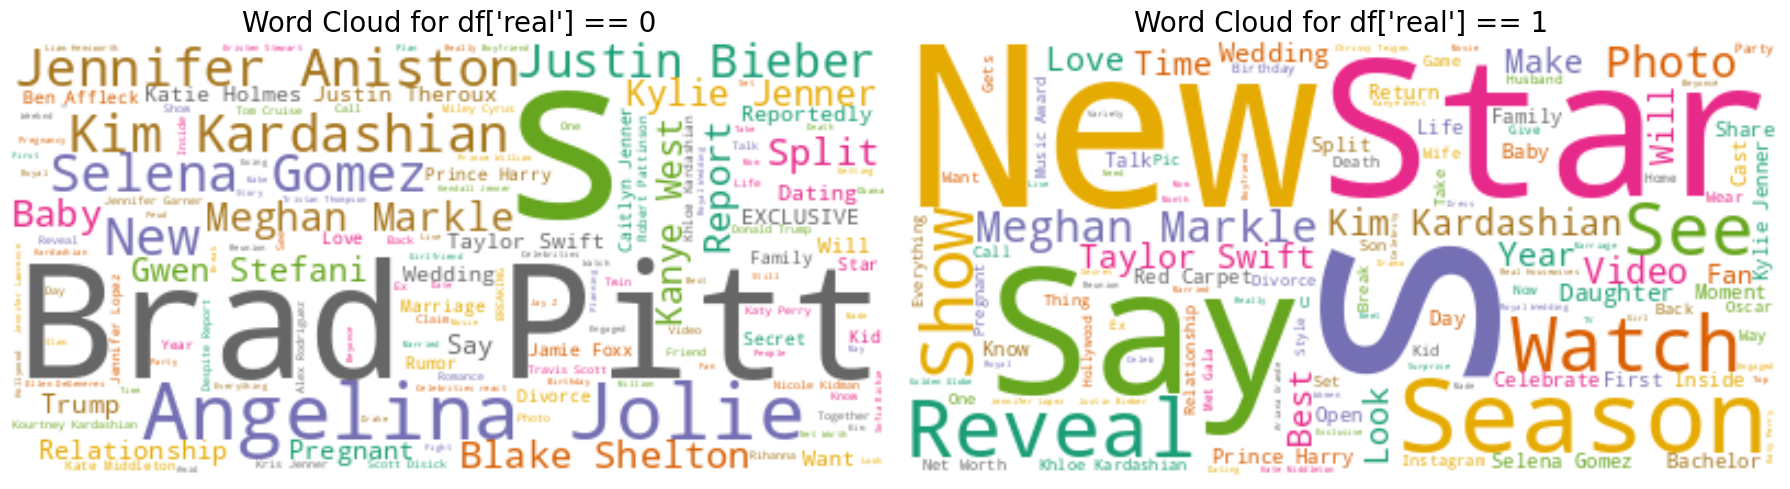

In [ ]:
generate_word_cloud(dataset = df, column1 = 'title')

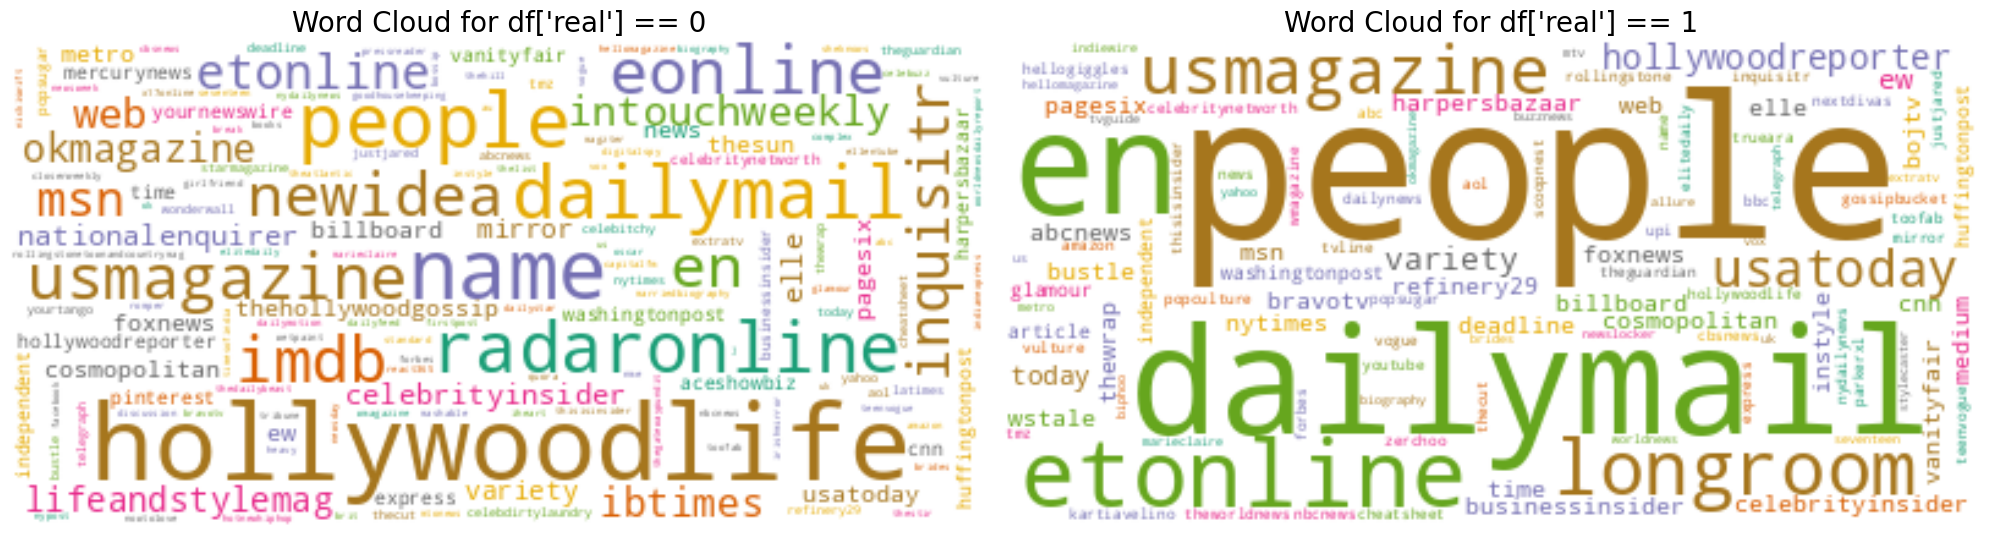

In [ ]:
generate_word_cloud(dataset = df, column1 = 'domain_name')

## Oversampling

The original dataset is unbalanced. Less than 25% is fake news and 75% real. Upsampling was used to improve balancing.

In [ ]:
df_majority = df[df['real'] == 1]
df_minority = df[(df['real'] == 0)]

df_minority_upsamlped = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)
df_upsampled = pd.concat([df_majority, df_minority_upsamlped])

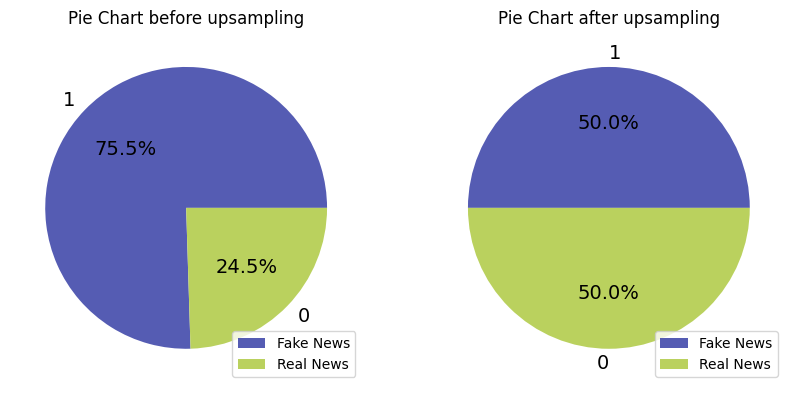

In [ ]:
counts_label = [df['real'].value_counts(), df_upsampled['real'].value_counts()]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, counts in enumerate(counts_label):
    ax[i].pie(counts,
              labels=counts.index,
              autopct='%1.1f%%',
              colors=['#555CB3', '#BAD15E'],
              textprops={'fontsize': 14})
    ax[i].set_title("Pie Chart " + ("before" if i == 0 else "after") + " upsampling")
    ax[i].legend(labels=['Fake News', 'Real News'], loc='lower right')

plt.show()

## Stopwords

In [ ]:
df_stopwords = df_upsampled.copy()

In [ ]:
remove_stopwords_and_punctuation(df = df_stopwords , columns = ['title', 'text'])

## Tokenizer

In [ ]:
#without stopwords

df_token = df_stopwords.copy()
tokenize(df=df_token, col='title')
df_token.head(3)

,title,tweet_num,real,domain_name
0,"[kandi, burruss, explodes, rape, accusation, '...",42,1,toofab
1,"[people, 's, choice, awards, 2018, best, red, ...",0,1,today
2,"[sophia, bush, sends, sweet, birthday, message...",63,1,etonline


In [ ]:
# with stopwords

df_token_stopwords = df_upsampled.copy()
df_token_stopwords['title'] = df_token_stopwords['title'].apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))

In [ ]:
tokenize(df=df_token_stopwords , col='title')
df_token_stopwords.head(3)

,title,tweet_num,real,domain_name
0,"[Kandi, Burruss, Explodes, Over, Rape, Accusat...",42,1,toofab
1,"[People, 's, Choice, Awards, 2018, :, The, bes...",0,1,today
2,"[Sophia, Bush, Sends, Sweet, Birthday, Message...",63,1,etonline


## SnowBall Stemming

In [ ]:
#without stopwords

df_stemm = df_token.copy()
df_stemm['title'] = df_stemm['title'].apply(stem_tokens)
df_stemm.head(3)

,title,tweet_num,real,domain_name
0,"[kandi, burruss, explod, rape, accus, real, ho...",42,1,toofab
1,"[peopl, 's, choic, award, 2018, best, red, car...",0,1,today
2,"[sophia, bush, send, sweet, birthday, messag, ...",63,1,etonline


In [ ]:
# with stopwords

df_stemm_stopwords = df_token_stopwords.copy()
df_stemm_stopwords['title'] = df_stemm_stopwords['title'].apply(stem_tokens)
df_stemm_stopwords.head(3)

,title,tweet_num,real,domain_name
0,"[kandi, burruss, explod, over, rape, accus, on...",42,1,toofab
1,"[peopl, 's, choic, award, 2018, :, the, best, ...",0,1,today
2,"[sophia, bush, send, sweet, birthday, messag, ...",63,1,etonline


## Bag-of-words algorithm

In [ ]:
#without stopwords

df_bow = df_stemm.copy()
df_bow = create_bow_df(df=df_bow, col='title')
df_bow.head(3)

,000,10,100,11,12,13,14,15,19,20,...,world,worri,worst,worth,would,year,york,youn,young,zayn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# with stopwords

df_bow_stopwords = df_stemm_stopwords.copy()
df_bow_stopwords = create_bow_df(df=df_bow_stopwords, col='title')
df_bow_stopwords.head(3)

,000,10,100,11,12,13,14,15,19,20,...,worst,worth,would,year,york,you,youn,young,your,zayn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Bag2Vec

In [ ]:
#without stopwords

df_b2v = df_stemm.copy()
df_b2v = create_b2v_df(df=df_b2v, col='title')
df_b2v.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-4.064293,2.906386,3.012028,2.119446,0.986231,-4.222770,1.774463,7.528948,-1.168458,0.056337,...,3.491701,-0.052793,2.658349,1.181972,4.579573,3.810948,1.687681,-0.557661,1.597355,2.131169
1,2.327293,-1.705814,5.883864,3.691160,-1.174351,-9.276704,2.540425,4.677197,1.598303,-0.344113,...,11.631930,3.205303,4.090872,0.586567,5.887866,5.020239,0.316151,0.341278,-0.164336,-7.108387
2,-3.934698,3.004118,2.988068,3.465664,3.327327,-4.965670,2.668906,9.227729,-1.575017,-0.261638,...,0.224592,2.155711,3.875038,1.750585,7.431313,5.689571,0.844288,-1.949382,2.197841,3.004029


In [ ]:
# with stopwords

df_b2v_stopwords = df_stemm_stopwords.copy()
df_b2v_stopwords = create_b2v_df(df=df_b2v_stopwords, col='title')
df_b2v_stopwords.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.794950,4.899481,2.540791,-0.359343,8.364217,-4.689557,-1.389480,4.680267,-8.080750,-2.665483,...,8.419596,6.069909,7.201976,11.574377,11.704208,11.054994,-2.068069,0.840743,-0.739932,-6.283693
1,-8.844929,3.441171,-1.044279,-2.720411,1.881807,-8.283774,9.255552,3.165019,0.204896,-1.463098,...,11.653946,4.404137,1.383362,1.253756,12.625485,7.891839,5.459636,-4.850472,0.277523,-9.573216
2,-0.066214,6.739446,-0.097373,-0.163000,8.049440,-4.812126,3.199115,10.396884,-4.785686,-8.948341,...,5.664158,1.515924,7.165156,0.455345,11.002188,3.237056,1.083221,-5.062228,-0.835805,-0.578716


## Sentence Transformer

In [ ]:
df_st = df_stopwords.copy()

In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [ ]:
X_st = df_st['title'].apply(lambda x: model.encode(x).tolist())

# Models - 1st root
*   cut stopwords: no
*   tokenize: yes
*   bag-of-words

In [ ]:
# extract X and y
X = df_bow_stopwords.values
tweet_num = df_stemm_stopwords['tweet_num'].values
X = np.concatenate((X, tweet_num.reshape(-1, 1)), axis=1)
y = df_stemm_stopwords['real'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-25 11:25:14,569] A new study created in memory with name: no-name-22c6e60f-fc75-457e-a708-4ffe79c78b72
<ipython-input-40-95620629b930>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2023-04-25 11:25:46,430] Trial 0 finished with value: 0.7946702241897583 and parameters: {'lr': 0.0002790886332203528, 'batch_size': 32, 'epochs': 26}. Best is trial 0 with value: 0.7946702241897583.
[I 2023-04-25 11:26:42,537] Trial 1 finished with value: 0.7965874075889587 and parameters: {'lr': 0.00035223397515810767, 'batch_size': 16, 'epochs': 35}. Best is trial 1 with value: 0.7965874075889587.
[I 2023-04-25 11:27:04,090] Trial 2 finished with value: 0.8000383377075195 and parameters: {'lr': 0.0026535287525209393, 'batch_size': 32, 'epochs': 20}. Best is trial 2 with

Best trial:
  Loss: 0.8000
  Params: 
    lr: 0.0026535287525209393
    batch_size: 32
    epochs: 20
Training set: loss=27.2623, accuracy=0.6111
Validation set: loss=20.0792, accuracy=0.7531
Test set: loss=21.2543, accuracy=0.7400


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9091, Validation accuracy = 0.7934
Fold 2: Train accuracy = 0.8182, Validation accuracy = 0.7985
Fold 3: Train accuracy = 0.5455, Validation accuracy = 0.7946
Fold 4: Train accuracy = 0.6364, Validation accuracy = 0.7785
Fold 5: Train accuracy = 0.8333, Validation accuracy = 0.7944
Test accuracy = 0.7966
Average train accuracy = 0.7485
Average validation accuracy = 0.7919


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.9355, Validation accuracy = 0.8716
Fold 2: Train accuracy = 0.9419, Validation accuracy = 0.8726
Fold 3: Train accuracy = 0.9482, Validation accuracy = 0.8817
Fold 4: Train accuracy = 0.9539, Validation accuracy = 0.8851
Fold 5: Train accuracy = 0.9436, Validation accuracy = 0.8806
Test accuracy = 0.8819
Average train accuracy = 0.9446
Average validation accuracy = 0.8783


# Models - 2nd root
*   cut stopwords: no
*   tokenize: yes
*   Bag2Vec

In [ ]:
# extract X and y
X = df_b2v_stopwords.values
tweet_num = df_stemm_stopwords['tweet_num'].values
X = np.concatenate((X, tweet_num.reshape(-1, 1)), axis=1)
y = df_stemm_stopwords['real'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-25 11:39:52,240] A new study created in memory with name: no-name-d71cd21b-346a-434f-9130-0211da78e1e2
<ipython-input-40-95620629b930>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2023-04-25 11:40:22,187] Trial 0 finished with value: 0.7160659432411194 and parameters: {'lr': 0.006283045481979634, 'batch_size': 64, 'epochs': 44}. Best is trial 0 with value: 0.7160659432411194.
[I 2023-04-25 11:40:36,204] Trial 1 finished with value: 0.7149156332015991 and parameters: {'lr': 0.0021445109722201517, 'batch_size': 64, 'epochs': 27}. Best is trial 0 with value: 0.7160659432411194.
[I 2023-04-25 11:40:46,191] Trial 2 finished with value: 0.6955521702766418 and parameters: {'lr': 6.571905000545752e-05, 'batch_size': 32, 'epochs': 13}. Best is trial 0 with v

Best trial:
  Loss: 0.7354
  Params: 
    lr: 0.00031193691625279474
    batch_size: 32
    epochs: 46
Training set: loss=19.8203, accuracy=0.7222
Validation set: loss=19.6502, accuracy=0.7205
Test set: loss=19.7095, accuracy=0.7147


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.7500, Validation accuracy = 0.7006
Fold 2: Train accuracy = 0.8750, Validation accuracy = 0.7248
Fold 3: Train accuracy = 1.0000, Validation accuracy = 0.7181
Fold 4: Train accuracy = 0.7500, Validation accuracy = 0.7204
Fold 5: Train accuracy = 0.7500, Validation accuracy = 0.7281
Test accuracy = 0.7232
Average train accuracy = 0.8250
Average validation accuracy = 0.7184


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.8079, Validation accuracy = 0.7940
Fold 2: Train accuracy = 0.8094, Validation accuracy = 0.7970
Fold 3: Train accuracy = 0.8073, Validation accuracy = 0.8030
Fold 4: Train accuracy = 0.7975, Validation accuracy = 0.8015
Fold 5: Train accuracy = 0.8063, Validation accuracy = 0.7991
Test accuracy = 0.8002
Average train accuracy = 0.8057
Average validation accuracy = 0.7989


# Models - 3rd root
*   cut stopwords: yes
*   tokenize: no
*   Sentence Transformer

In [ ]:
X = X_st.copy()
y = df_stopwords['real'].values

In [ ]:
X_st_tensor = torch.tensor(X_st, dtype=torch.float32)

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X_st_tensor, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-25 13:49:51,203] A new study created in memory with name: no-name-1a35bed9-1deb-4ae3-9add-c70eb168b6c2
<ipython-input-40-95620629b930>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-40-95620629b930>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
[I 2023-04-25 13:50:19,886] Trial 0 finished with value: 0.7611196041107178 and parameters: {'lr': 0.0009519233772137443, 'batch_size': 32, 'epochs': 34}. Best is trial 0 with value: 0.7611196041107178.
[I 2023-04-25 13:51:01,372] Trial 1 finished with value: 0.7337039709091187 and parameters: {'lr': 0

Best trial:
  Loss: 0.7611
  Params: 
    lr: 0.0009519233772137443
    batch_size: 32
    epochs: 34
Training set: loss=5.5567, accuracy=0.9444
Validation set: loss=25.4277, accuracy=0.7276
Test set: loss=26.3508, accuracy=0.7172


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_st_tensor, y, test_size=0.2)

In [ ]:
perform_kfold_cross_validation(X_train,  y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

/content/drive/My Drive/Colab Notebooks/upskill/Fake News Classification/modeling_scripts.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Fold 1: Train accuracy = 0.6667, Validation accuracy = 0.7425
Fold 2: Train accuracy = 0.6154, Validation accuracy = 0.7354
Fold 3: Train accuracy = 0.7692, Validation accuracy = 0.7251
Fold 4: Train accuracy = 0.8462, Validation accuracy = 0.7512
Fold 5: Train accuracy = 0.3846, Validation accuracy = 0.7381
Test accuracy = 0.7423
Average train accuracy = 0.6564
Average validation accuracy = 0.7385


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_st_tensor, y, test_size=0.2)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

/content/drive/My Drive/Colab Notebooks/upskill/Fake News Classification/modeling_scripts.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)


Fold 1: Train accuracy = 0.8064, Validation accuracy = 0.7624
Fold 2: Train accuracy = 0.8397, Validation accuracy = 0.7974
Fold 3: Train accuracy = 0.8236, Validation accuracy = 0.7859
Fold 4: Train accuracy = 0.7987, Validation accuracy = 0.7600
Fold 5: Train accuracy = 0.8175, Validation accuracy = 0.7728
Test accuracy = 0.7873
Average train accuracy = 0.8172
Average validation accuracy = 0.7757


# Models - 4th root
*   cut stopwords: yes
*   tokenize: yes
*   convert to stem: yes
*   bag-of-words



In [ ]:
# extract X and y
X = df_bow.values
tweet_num = df_stemm['tweet_num'].values
X = np.concatenate((X, tweet_num.reshape(-1, 1)), axis=1)
y = df_stemm['real'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-25 11:55:04,015] A new study created in memory with name: no-name-6b4aea17-de94-477a-89e6-4916ed5f4ae0
<ipython-input-40-95620629b930>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2023-04-25 11:55:33,575] Trial 0 finished with value: 0.7881518602371216 and parameters: {'lr': 0.00020019525124659527, 'batch_size': 32, 'epochs': 26}. Best is trial 0 with value: 0.7881518602371216.
[I 2023-04-25 11:55:58,669] Trial 1 finished with value: 0.735237717628479 and parameters: {'lr': 0.010464121456351899, 'batch_size': 32, 'epochs': 22}. Best is trial 0 with value: 0.7881518602371216.
[I 2023-04-25 11:57:10,521] Trial 2 finished with value: 0.7666794657707214 and parameters: {'lr': 1.463213060414594e-05, 'batch_size': 16, 'epochs': 46}. Best is trial 0 with v

Best trial:
  Loss: 0.7916
  Params: 
    lr: 0.0007871322435920784
    batch_size: 64
    epochs: 48
Training set: loss=16.8862, accuracy=0.7222
Validation set: loss=15.9087, accuracy=0.7414
Test set: loss=14.6919, accuracy=0.7500


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 1.0000, Validation accuracy = 0.7619
Fold 2: Train accuracy = 0.8750, Validation accuracy = 0.7876
Fold 3: Train accuracy = 0.8750, Validation accuracy = 0.7931
Fold 4: Train accuracy = 0.8750, Validation accuracy = 0.7951
Fold 5: Train accuracy = 0.8750, Validation accuracy = 0.7787
Test accuracy = 0.8115
Average train accuracy = 0.9000
Average validation accuracy = 0.7833


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.5028, Validation accuracy = 0.4850
Fold 2: Train accuracy = 0.9450, Validation accuracy = 0.8813
Fold 3: Train accuracy = 0.9134, Validation accuracy = 0.8509
Fold 4: Train accuracy = 0.9386, Validation accuracy = 0.8734
Fold 5: Train accuracy = 0.9425, Validation accuracy = 0.8745
Test accuracy = 0.8919
Average train accuracy = 0.8485
Average validation accuracy = 0.7930


# Models - 5th root

*   cut stopwords: yes
*   tokenize: yes
*   convert to stem: yes
*   Bag2Vec

In [ ]:
# extract X and y
X = df_b2v.values
tweet_num = df_stemm['tweet_num'].values
X = np.concatenate((X, tweet_num.reshape(-1, 1)), axis=1)
y = df_stemm['real'].values

## Logistic Regression with Optuna

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

In [ ]:
create_logistic_regression(X_train, X_val, X_test, y_train, y_val, y_test)

[I 2023-04-25 12:15:37,436] A new study created in memory with name: no-name-d535c271-1637-40ea-9c40-f603cd2fffbf
<ipython-input-40-95620629b930>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2023-04-25 12:15:49,082] Trial 0 finished with value: 0.6974693536758423 and parameters: {'lr': 3.6169910444013934e-05, 'batch_size': 64, 'epochs': 23}. Best is trial 0 with value: 0.6974693536758423.
[I 2023-04-25 12:16:13,859] Trial 1 finished with value: 0.7083972096443176 and parameters: {'lr': 4.4094215904479857e-05, 'batch_size': 64, 'epochs': 47}. Best is trial 1 with value: 0.7083972096443176.
[I 2023-04-25 12:16:48,792] Trial 2 finished with value: 0.7120398879051208 and parameters: {'lr': 3.3038468912275604e-05, 'batch_size': 32, 'epochs': 44}. Best is trial 2 wi

Best trial:
  Loss: 0.7416
  Params: 
    lr: 0.0210410401106623
    batch_size: 64
    epochs: 38
Training set: loss=50.0000, accuracy=0.5000
Validation set: loss=49.8083, accuracy=0.5019
Test set: loss=49.7891, accuracy=0.5021


## Cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
perform_kfold_cross_validation(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.6250, Validation accuracy = 0.7399
Fold 2: Train accuracy = 0.7500, Validation accuracy = 0.7157
Fold 3: Train accuracy = 0.6250, Validation accuracy = 0.7100
Fold 4: Train accuracy = 0.6250, Validation accuracy = 0.7298
Fold 5: Train accuracy = 0.7500, Validation accuracy = 0.7271
Test accuracy = 0.7154
Average train accuracy = 0.6750
Average validation accuracy = 0.7245


## More complex NN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
create_more_complex_nn(X_train, y_train, X_test, y_test, n_splits=5, batch_size=16, learning_rate=1e-3, num_epochs=10)

Fold 1: Train accuracy = 0.8138, Validation accuracy = 0.8055
Fold 2: Train accuracy = 0.7932, Validation accuracy = 0.7933
Fold 3: Train accuracy = 0.8206, Validation accuracy = 0.8116
Fold 4: Train accuracy = 0.8131, Validation accuracy = 0.7978
Fold 5: Train accuracy = 0.8098, Validation accuracy = 0.8114
Test accuracy = 0.8085
Average train accuracy = 0.8101
Average validation accuracy = 0.8039


# Similar news

In [ ]:
# create the tf-idf vectorizer
vectorizer = TfidfVectorizer()

# fit the vectorizer on the news titles
tfidf_matrix = vectorizer.fit_transform(df['title'])

# calculate cosine distance between all pairs of news titles
cosine_sim = 1 - cosine_distances(tfidf_matrix)

In [ ]:
# the index of the first article
index = 0

# get the cosine distances of the first article to all other articles
distances = cosine_sim[index]

# sort the distances in descending order
sorted_distances = sorted(enumerate(distances), key=lambda x: x[1], reverse=True)

# print the top 5 most similar articles
for i, distance in sorted_distances[1:6]:
    print(df.loc[i, 'title'])


Dynasty Fashion: An Interview With the Cast and Wardrobe Stylist
Selena Gomez's best friend Francia Raisa speaks out about donating her kidney to the star
‘Bachelor in Paradise’ stars Jade and Tanner Tolbert are expecting a baby
Michelle Tanner
How to watch the royal wedding of Prince Harry and Meghan Markle
